# ASR for Farsi


* [Setup and Imports](#setup-and-imports)
* [Load and Preprocess Data](#load-and-preprocess-data)
* [Fine-Tuning the Model](#fine-tuning-the-model)

## Setup and Imports

---

### Import required libraries

In [ ]:
!pip install -U datasets
!pip install -U transformers
!pip install torchaudio
!pip install librosa
!pip install jiwer
!pip install hazm
!pip install num2fawords
!pip install accelerate

In [2]:
import json
import time

import re
from hazm import Normalizer

import torch
import torchaudio
import torchaudio.transforms as transforms
import librosa

import numpy as np
from jiwer import wer

from datasets import load_dataset, Audio, load_metric

from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC, TrainingArguments, Trainer

## Load and Preprocess Data

---

### Load dataset from HuggingFace

In [3]:
from huggingface_hub import login
login()

In [4]:
common_voice_train = load_dataset("mozilla-foundation/common_voice_6_1", "fa", split="train", trust_remote_code=True)
common_voice_test = load_dataset("mozilla-foundation/common_voice_6_1", "fa", split="test", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating other split: 0 examples [00:00, ? examples/s]

Generating invalidated split: 0 examples [00:00, ? examples/s]

### Remove Unnecessary Columns

In [5]:
columns_to_remove = ['down_votes', 'gender', 'locale', 'segment', 'up_votes', 'accent', 'age', 'client_id']

print("Train Set Columns (Before Drop):", common_voice_train.column_names)
print("Test Set Columns (Before Drop):", common_voice_test.column_names)

common_voice_train = common_voice_train.remove_columns(columns_to_remove)
common_voice_test = common_voice_test.remove_columns(columns_to_remove)

print("Train Set Columns (After Drop):", common_voice_train.column_names)
print("Test Set Columns (After Drop):", common_voice_test.column_names)

Train Set Columns (Before Drop): ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment']
Test Set Columns (Before Drop): ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment']
Train Set Columns (After Drop): ['path', 'audio', 'sentence']
Test Set Columns (After Drop): ['path', 'audio', 'sentence']


### Filter Audio

In [6]:
def filter_train_audio(batch):
    duration = len(batch["audio"]["array"]) / batch["audio"]["sampling_rate"]
    return 4.0 <= duration <= 6.0

def filter_test_audio(batch):
    duration = len(batch["audio"]["array"]) / batch["audio"]["sampling_rate"]
    return duration < 15.0

print("Common Voice Train Length (Before Filter):", len(common_voice_train))
print("Common Voice Test Length (Before Filter):", len(common_voice_test))

common_voice_train = common_voice_train.filter(filter_train_audio)
common_voice_test = common_voice_test.filter(filter_test_audio)

print("Common Voice Train Length (After Filter):", len(common_voice_train))
print("Common Voice Test Length (After Filter):", len(common_voice_test))

Common Voice Train Length (Before Filter): 7593
Common Voice Test Length (Before Filter): 5213


Filter:   0%|          | 0/7593 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5213 [00:00<?, ? examples/s]

Common Voice Train Length (After Filter): 2217
Common Voice Test Length (After Filter): 5212


### Preprocessing

In [7]:
chars_to_ignore = [
    ",", "?", ".", "!", "-", ";", ":", '""', "%", "'", '"', "�", "&",
    "#", "!", "؟", "?", "«", "»", "،", "(", ")", "؛", "'ٔ", "٬",'ٔ', ",", "?",
    ".", "!", "-", ";", ":",'"',"“", "%", "‘", "”", "=", "–", "…", "_", "”", '“', '„',
    'ā', 'š'
]


chars_to_mapping = {
    'ك': 'ک', 'دِ': 'د', 'بِ': 'ب', 'زِ': 'ز', 'ذِ': 'ذ', 'شِ': 'ش', 'سِ': 'س', 'ى': 'ی',
    'ي': 'ی', 'أ': 'ا', 'ؤ': 'و', "ے": "ی", "ۀ": "ه", "ﭘ": "پ", "ﮐ": "ک", "ﯽ": "ی",
    "ﺎ": "ا", "ﺑ": "ب", "ﺘ": "ت", "ﺧ": "خ", "ﺩ": "د", "ﺱ": "س", "ﻀ": "ض", "ﻌ": "ع",
    "ﻟ": "ل", "ﻡ": "م", "ﻢ": "م", "ﻪ": "ه", "ﻮ": "و", 'ﺍ': "ا", 'ة': "ه",
    'ﯾ': "ی", 'ﯿ': "ی", 'ﺒ': "ب", 'ﺖ': "ت", 'ﺪ': "د", 'ﺮ': "ر", 'ﺴ': "س", 'ﺷ': "ش",
    'ﺸ': "ش", 'ﻋ': "ع", 'ﻤ': "م", 'ﻥ': "ن", 'ﻧ': "ن", 'ﻭ': "و", 'ﺭ': "ر", "ﮔ": "گ",

    # "ها": "  ها", "ئ": "ی",
    "۱۴ام": "۱۴ ام",

    "a": " ای ", "b": " بی ", "c": " سی ", "d": " دی ", "e": " ایی ", "f": " اف ",
    "g": " جی ", "h": " اچ ", "i": " آی ", "j": " جی ", "k": " کی ", "l": " ال ",
    "m": " ام ", "n": " ان ", "o": " او ", "p": " پی ", "q": " کیو ", "r": " آر ",
    "s": " اس ", "t": " تی ", "u": " یو ", "v": " وی ", "w": " دبلیو ", "x": " اکس ",
    "y": " وای ", "z": " زد ",
    "\u200c": " ", "\u200d": " ", "\u200e": " ", "\u200f": " ", "\ufeff": " ",
}

In [8]:
_normalizer = Normalizer()

def multiple_replace(text, chars_to_mapping):
    pattern = "|".join(map(re.escape, chars_to_mapping.keys()))
    return re.sub(pattern, lambda m: chars_to_mapping[m.group()], str(text))

def remove_special_characters(text, chars_to_ignore_regex):
    text = re.sub(chars_to_ignore_regex, '', text).lower() + " "
    return text

def normalizer(batch, chars_to_ignore, chars_to_mapping):
    chars_to_ignore_regex = f"""[{"".join(chars_to_ignore)}]"""
    text = batch["sentence"].lower().strip()

    text = _normalizer.normalize(text)
    text = multiple_replace(text, chars_to_mapping)
    text = remove_special_characters(text, chars_to_ignore_regex)
    text = re.sub(" +", " ", text)
    text = text.strip() + " "

    batch["sentence"] = text
    return batch

common_voice_train = common_voice_train.map(
    normalizer,
    fn_kwargs={"chars_to_ignore": chars_to_ignore, "chars_to_mapping": chars_to_mapping}
)

common_voice_test = common_voice_test.map(
    normalizer,
    fn_kwargs={"chars_to_ignore": chars_to_ignore, "chars_to_mapping": chars_to_mapping}
)

Map:   0%|          | 0/2217 [00:00<?, ? examples/s]

Map:   0%|          | 0/5212 [00:00<?, ? examples/s]

In [9]:
for i in range(3):
  print("Data", i)
  print(common_voice_train[i]["sentence"])
  print(common_voice_test[i]["sentence"])

Data 0
چه جوری آخه برانکو با دست خالی تیمشو برد فینال 
از هم جداشدن خیلی سخته 
Data 1
اون میوه هات رو بردار 
بله مطمئن باشید هستم 
Data 2
خوبه که جامعه پزشکی 
تقریبا صدو پنجاه گز دورتر از جاده 


### Create Character Dictionary

In [10]:
def extract_all_chars(batch):
    all_text = " ".join(batch["sentence"])
    vocab = list(set(all_text))
    return {"vocab": [vocab], "all_text": [all_text]}

vocab_train = common_voice_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_train.column_names)
vocab_test = common_voice_test.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=common_voice_test.column_names)

vocab_list = list(set(vocab_train["vocab"][0]) | set(vocab_test["vocab"][0]))
vocab_list.sort()

if " " in vocab_list:
    vocab_list.remove(" ")

print("Vocab List Length:", len(vocab_list))
print(vocab_list)

vocab_dict = {
    "<pad>": 0,
    "<s>": 1,
    "</s>": 2,
    "<unk>": 3,
    "|": 4
}

current_index = 5
for char in vocab_list:
    if char not in vocab_dict:
        vocab_dict[char] = current_index
        current_index += 1

Map:   0%|          | 0/2217 [00:00<?, ? examples/s]

Map:   0%|          | 0/5212 [00:00<?, ? examples/s]

Vocab List Length: 35
['ء', 'آ', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ل', 'م', 'ن', 'ه', 'و', 'پ', 'چ', 'ژ', 'ک', 'گ', 'ی']


In [11]:
print("Dictionary Length:", len(vocab_dict))
print(vocab_dict)

Dictionary Length: 40
{'<pad>': 0, '<s>': 1, '</s>': 2, '<unk>': 3, '|': 4, 'ء': 5, 'آ': 6, 'ئ': 7, 'ا': 8, 'ب': 9, 'ت': 10, 'ث': 11, 'ج': 12, 'ح': 13, 'خ': 14, 'د': 15, 'ذ': 16, 'ر': 17, 'ز': 18, 'س': 19, 'ش': 20, 'ص': 21, 'ض': 22, 'ط': 23, 'ظ': 24, 'ع': 25, 'غ': 26, 'ف': 27, 'ق': 28, 'ل': 29, 'م': 30, 'ن': 31, 'ه': 32, 'و': 33, 'پ': 34, 'چ': 35, 'ژ': 36, 'ک': 37, 'گ': 38, 'ی': 39}


### Save unique characters in JSON

In [12]:
vocab_file = "vocab.json"
with open(vocab_file, 'w') as vf:
    json.dump(vocab_dict, vf)

### Resample audio to 16kHz

In [13]:
def speech_file_to_array_fn(batch):
    target_sampling_rate = 16000
    speech_array, sampling_rate = librosa.load(batch["path"])
    speech_array = speech_array.squeeze()
    speech_tensor = torch.tensor(speech_array)
    transform = transforms.Resample(sampling_rate, target_sampling_rate)
    resampled_tensor = transform(speech_tensor)

    batch["speech"] = resampled_tensor.numpy()
    batch["sampling_rate"] = target_sampling_rate
    batch["duration_in_seconds"] = len(batch["speech"]) / target_sampling_rate
    batch["target_text"] = batch["sentence"]

    return batch

common_voice_train = common_voice_train.map(speech_file_to_array_fn)
common_voice_test = common_voice_test.map(speech_file_to_array_fn)

Map:   0%|          | 0/2217 [00:00<?, ? examples/s]

Map:   0%|          | 0/5212 [00:00<?, ? examples/s]

## Fine-Tuning the Model

---

### Tokenizer



In [14]:
tokenizer = Wav2Vec2CTCTokenizer(
    vocab_file=vocab_file,
    unk_token="<unk>",
    pad_token="<pad>",
    bos_token="<s>",
    eos_token="</s>",
    word_delimiter_token="|",
    do_lower_case=False
)

text = "سلام من علیرضا دستمالچی ساعی هستم"
text_with_special_tokens = f"<s> {text} </s>"

tokenized_text = tokenizer.tokenize(text_with_special_tokens)
encoded_text = tokenizer.encode(text_with_special_tokens)
decoded_text = tokenizer.decode(encoded_text)

print("Tokenized text:", " ".join(tokenized_text))
print("Encoded text:", encoded_text)
print("Decoded text:", decoded_text)

Tokenized text: <s> س ل ا م | م ن | ع ل ی ر ض ا | د س ت م ا ل چ ی | س ا ع ی | ه س ت م </s>
Encoded text: [1, 19, 29, 8, 30, 4, 30, 31, 4, 25, 29, 39, 17, 22, 8, 4, 15, 19, 10, 30, 8, 29, 35, 39, 4, 19, 8, 25, 39, 4, 32, 19, 10, 30, 2]
Decoded text: <s>سلام من علیرضا دستمالچی ساعی هستم</s>


### Feature Extracture

In [15]:
feature_extractor = Wav2Vec2FeatureExtractor(
    feature_size=1,
    sampling_rate=16000,
    padding_value=0.0,
    do_normalize=True,
    return_attention_mask=True,
)

### Processor

In [16]:
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

### Data Collator

In [17]:
def prepare_dataset(batch):
    assert (
        len(set(batch["sampling_rate"])) == 1
    ), f"Make sure all inputs have the same sampling rate of {processor.feature_extractor.sampling_rate}."

    batch["input_values"] = processor(batch["speech"], sampling_rate=16000).input_values

    with processor.as_target_processor():
        batch["labels"] = processor(batch["target_text"]).input_ids
    return batch


common_voice_train = common_voice_train.map(prepare_dataset, remove_columns=common_voice_train.column_names, batch_size=12, num_proc=4, batched=True)
common_voice_test = common_voice_test.map(prepare_dataset, remove_columns=common_voice_test.column_names, batch_size=12, num_proc=4, batched=True)

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=4):   0%|          | 0/2217 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/pyth

Map (num_proc=4):   0%|          | 0/5212 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

In [18]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [19]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

### Evaluation Metric

In [20]:
import random

wer_metric = load_metric("wer", trust_remote_code=True)

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)

    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    if isinstance(label_str, list):
        if isinstance(pred_str, list) and len(pred_str) == len(label_str):
            for index in random.sample(range(len(label_str)), 2):
                print(f'reference: "{label_str[index]}"')
                print(f'predicted: "{pred_str[index]}"')

        else:
            for index in random.sample(range(len(label_str)), 2):
                print(f'reference: "{label_str[index]}"')
                print(f'predicted: "{pred_str}"')

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

<ipython-input-20-373bca42d2b4>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer", trust_remote_code=True)


### Load Model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-xlsr-53",
                                       attention_dropout=0.1,
                                       gradient_checkpointing=True,
                                       ctc_loss_reduction="mean",
                                       ctc_zero_infinity=True,
                                       bos_token_id=processor.tokenizer.bos_token_id,
                                       eos_token_id=processor.tokenizer.eos_token_id,
                                       pad_token_id=processor.tokenizer.pad_token_id,
                                       vocab_size=len(processor.tokenizer.get_vocab())).to(device)

model.freeze_feature_extractor()

Using device: cuda


config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:2284: FutureWarning: The method `freeze_feature_extractor` is deprecated and will be removed in Transformers v5. Please use the equivalent `freeze_feature_encoder` method instead.
  warnings.warn(


### Define Trainer

In [22]:
import datetime
import matplotlib.pyplot as plt
from transformers import TrainerCallback, TrainerState, TrainerControl

class SaveModelCallback(TrainerCallback):

    def on_epoch_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        output_dir = f"{args.output_dir}/checkpoint-{int(state.epoch)}"
        kwargs["model"].save_pretrained(output_dir)
        kwargs["tokenizer"].save_pretrained(output_dir)
        print(f"Model saved at epoch {int(state.epoch)} to {output_dir}")


    def on_train_end(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        iterations = []
        loss_values = []

        for log in state.log_history:
            if 'loss' in log and 'step' in log:
                iterations.append(log['step'])
                loss_values.append(log['loss'])

        plt.figure(figsize=(10, 5))
        plt.plot(iterations, loss_values, label="Training Loss")
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training Loss over Iterations')
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{args.output_dir}/training_loss_plot.png")
        plt.show()
        print("Training loss plot saved.")

In [23]:
training_args = TrainingArguments(
    output_dir="./wav2vec2-large-xlsr-persian-demo",
    group_by_length=True,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    gradient_accumulation_steps=2,
    eval_strategy="steps",
    num_train_epochs=5,
    fp16=True,
    save_steps=500,
    eval_steps=500,
    logging_steps=500,
    learning_rate=1e-4,
    warmup_steps=1000,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=common_voice_train,
    eval_dataset=common_voice_test,
    tokenizer=processor.feature_extractor,
    callbacks=[SaveModelCallback()]
)

### Train Model

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss


Model saved at epoch 0 to ./wav2vec2-large-xlsr-persian-demo/checkpoint-0
Model saved at epoch 2 to ./wav2vec2-large-xlsr-persian-demo/checkpoint-2
Model saved at epoch 2 to ./wav2vec2-large-xlsr-persian-demo/checkpoint-2
Model saved at epoch 4 to ./wav2vec2-large-xlsr-persian-demo/checkpoint-4
Model saved at epoch 4 to ./wav2vec2-large-xlsr-persian-demo/checkpoint-4


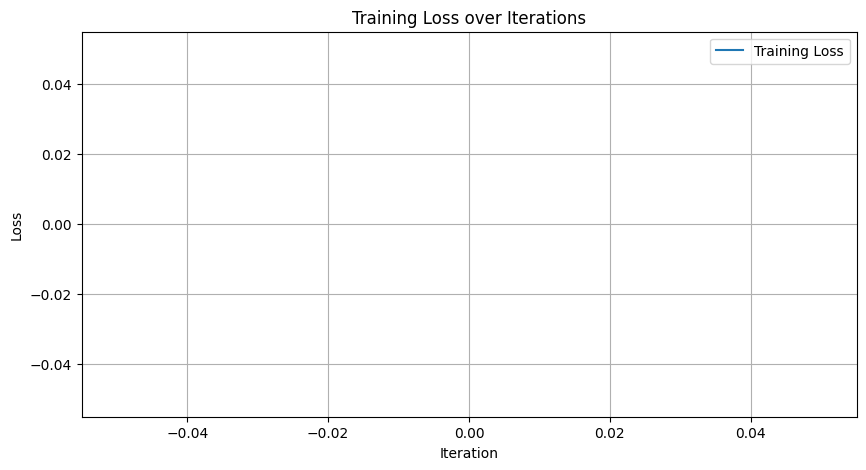

Training loss plot saved.
Training time: 19.67 minutes


In [24]:
start_time = time.time()
trainer.train()
end_time = time.time()
train_time = end_time - start_time

print(f"Training time: {train_time / 60:.2f} minutes")

## Model Evaluation

In [25]:
eval_results = trainer.evaluate()

print(f"Evaluation Results: {eval_results}")

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:157: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


reference: "همین الان راننده تاکسی گفت از بالا رسوندن بازی دیشب مساوی شه تا شلوغ نشه"
predicted: ""
reference: "یه مادرشوهر دارم گفته بریم از دوستش مبل بخریم و خودش برامون تخفیف آنچنانی میگیره"
predicted: ""
Evaluation Results: {'eval_loss': 3.0445730686187744, 'eval_wer': 1.0, 'eval_runtime': 373.5866, 'eval_samples_per_second': 13.951, 'eval_steps_per_second': 1.164, 'epoch': 4.972972972972973}


### Final Report

In [26]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

num_train_files = len(common_voice_train)
num_test_files = len(common_voice_test)

wer = eval_results['eval_wer']

report = {
    "Batch Size": training_args.per_device_train_batch_size,
    "Num Epochs": training_args.num_train_epochs,
    "Training Files": num_train_files,
    "Testing Files": num_test_files,
    "Training Time (minutes)": train_time/60,
    "Total Parameters": total_params,
    "Trainable Parameters": trainable_params,
    "WER (Word Error Rate)": wer
}

for key, value in report.items():
    print(f"{key}: {value}")

Batch Size: 12
Num Epochs: 5
Training Files: 2217
Testing Files: 5212
Training Time (minutes): 19.666995334625245
Total Parameters: 315479720
Trainable Parameters: 311269544
WER (Word Error Rate): 1.0


### Save Model

In [27]:
!huggingface-cli whoami

AlirezaSaei
orgs:  IsfahanUniversity


In [28]:
model.save_pretrained("./wav2vec2-large-xlsr-persian-fine-tuned", push_to_hub=True)

tokenizer.save_pretrained("./wav2vec2-large-xlsr-persian-fine-tuned", push_to_hub=True)

feature_extractor.save_pretrained("./wav2vec2-large-xlsr-persian-fine-tuned", push_to_hub=True)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

['./wav2vec2-large-xlsr-persian-fine-tuned/preprocessor_config.json']